SARIMAX Model

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [40]:
# Load citywide daily crash counts
daily_city = pd.read_parquet('../data/processed/daily_city_crashes.parquet')

# Make sure date is datetime
daily_city['crash_date'] = pd.to_datetime(daily_city['crash_date'])

# Set index
daily_city = daily_city.set_index('crash_date')

daily_city.head()

,total_crashes
crash_date,
2012-07-01,380
2012-07-02,395
2012-07-03,476
2012-07-04,297
2012-07-05,422


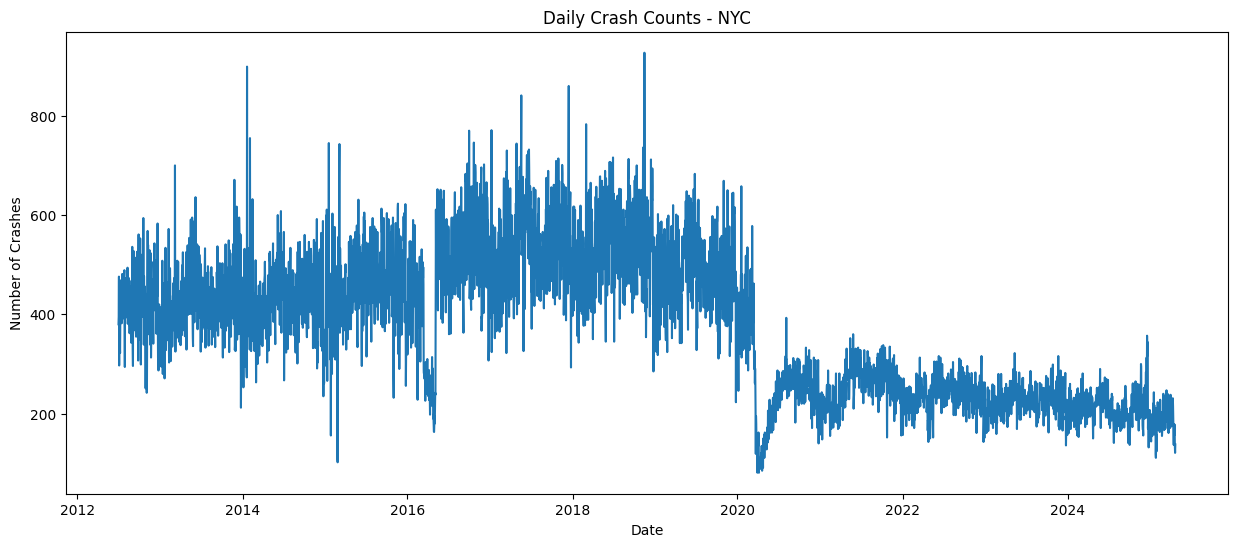

In [41]:
# Plot crash counts over time
plt.figure(figsize=(15,6))
plt.plot(daily_city['total_crashes'])
plt.title('Daily Crash Counts - NYC')
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.show()

In [42]:
# Train-test split (1 year holdout)
train = daily_city.iloc[:-365]
test = daily_city.iloc[-365:]

print(f"Train period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")

Train period: 2012-07-01 00:00:00 to 2024-04-22 00:00:00
Test period: 2024-04-23 00:00:00 to 2025-04-22 00:00:00


In [43]:
# Add day-of-week feature
train['dow'] = train.index.dayofweek  # Monday=0, Sunday=6
test['dow'] = test.index.dayofweek


/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_18695/2916938817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dow'] = train.index.dayofweek  # Monday=0, Sunday=6
/var/folders/_6/p9nq2tdd6418xp1vt5dxwqhm0000gn/T/ipykernel_18695/2916938817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['dow'] = test.index.dayofweek


In [44]:
train_exog = pd.get_dummies(train['dow'], drop_first=True).astype(int)
test_exog = pd.get_dummies(test['dow'], drop_first=True).astype(int)


In [45]:
# Fit SARIMAX with exogenous day-of-week
sarima_model = SARIMAX(
    train['total_crashes'],
    exog=train_exog,  # use precomputed variable
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)


sarima_result = sarima_model.fit(disp=False)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


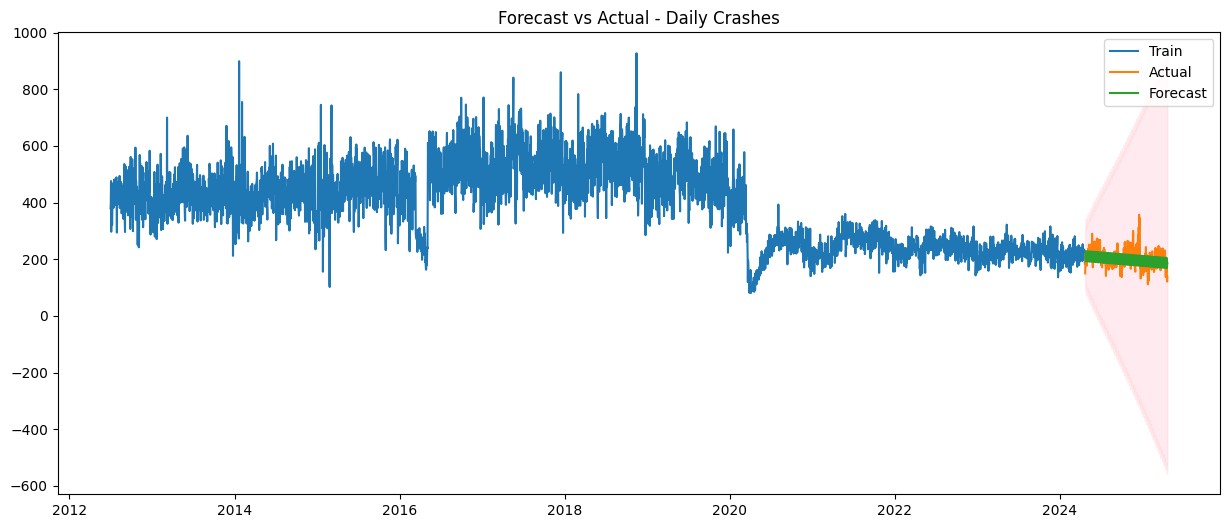

In [46]:
# Forecast
forecast = sarima_result.get_forecast(steps=len(test), exog=test_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(15,6))
plt.plot(train.index, train['total_crashes'], label='Train')
plt.plot(test.index, test['total_crashes'], label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast vs Actual - Daily Crashes')
plt.legend()
plt.show()


In [47]:
# Metrics
mae = mean_absolute_error(test['total_crashes'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['total_crashes'], forecast_mean))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 24.42
RMSE: 32.57


Prophet Model

Importing plotly failed. Interactive plots will not work.
14:58:13 - cmdstanpy - INFO - Chain [1] start processing
14:58:22 - cmdstanpy - INFO - Chain [1] done processing


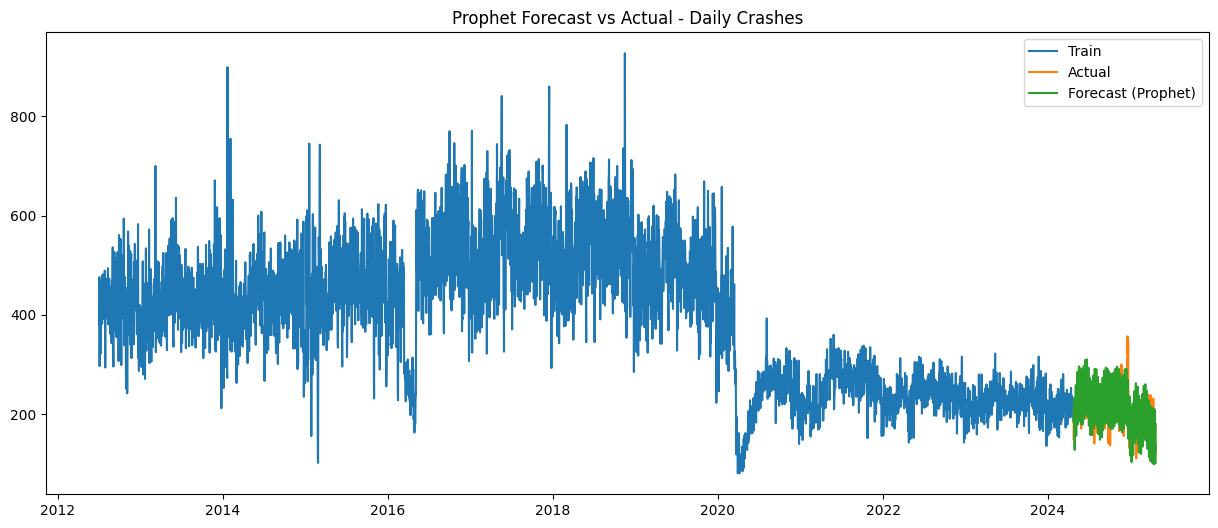

Prophet MAE: 34.62
Prophet RMSE: 43.29


In [48]:
from prophet import Prophet

# Prophet expects columns 'ds' (date) and 'y' (value)
prophet_df = daily_city.reset_index().rename(columns={
    'crash_date': 'ds',
    'total_crashes': 'y'
})

# Train/test split (same as SARIMA: last 365 days held out)
prophet_train = prophet_df.iloc[:-365]
prophet_test = prophet_df.iloc[-365:]

# Initialize Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Fit Prophet model
prophet_model.fit(prophet_train)

# Create dataframe for future dates
future = prophet_model.make_future_dataframe(periods=365)

# Forecast
forecast = prophet_model.predict(future)

# Extract forecast for test period
prophet_forecast = forecast.set_index('ds').loc[prophet_test['ds'], 'yhat']

# Plot forecast vs actual
plt.figure(figsize=(15,6))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Train')
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual')
plt.plot(prophet_test['ds'], prophet_forecast, label='Forecast (Prophet)')
plt.title('Prophet Forecast vs Actual - Daily Crashes')
plt.legend()
plt.show()

# Evaluation
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast))

print(f"Prophet MAE: {prophet_mae:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")

In [49]:
import joblib
from pathlib import Path

# Create model directory if it doesn't exist
Path('../models/crash_count_forecast').mkdir(parents=True, exist_ok=True)

# Save trained SARIMA model
joblib.dump(sarima_result, '../models/crash_count_forecast/sarima_model.pkl')

print("SARIMA model saved successfully.")

SARIMA model saved successfully.
